# MNIST 데이터셋을 활용한 연합학습
- pytorch 모델의 연합학습 코드 이해
- 클라이언트의 데이터 분포가 균등하지 않을 때(non-iid)상황 이해

## 주피터 터미널에서 가상환경 진입 후 matplotlib 설치 필요
## pip install matplotlib
## (주피터 터미널에서 붙여넣기는 ctrl + shift + v)

## import

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transfroms
import numpy as np
from torch.utils.data import DataLoader
from collections import OrderedDict
import flwr as fl
import math
import matplotlib.pyplot as plt



### (주의 사항) 수강생 모두가 동일한 GPU를 사용하면 속도가 매우 느려지거나 오류가 발생할 수 있음
### 아래와 같이 각 조는 개별 GPU를 사용하기로 함
- 1조 : cuda:1
- 2조 : cuda:2
- 3조 : cuda:3

In [7]:
''' 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0') # 해당 조의 GPU 번호로 변경 ex) 1조 : cuda:1
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.12.1+cu113  Device: cuda:0


## MNIST 데이터셋
- 0부터 9까지의 숫자를 손글씨로 쓴 이미지들로 구성
- 각 이미지는 28x28 픽셀 크기의 흑백 이미지로 총 784(=28x28)개의 픽셀로 이루어져 있음
- 머신 러닝 분야에서 가장 많이 사용되는 벤치마크 데이터셋 중 하나

In [8]:
train_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transfroms.Compose([
        transfroms.ToTensor() # 데이터를 0에서 255까지 있는 값을 0에서 1사이 값으로 변환
    ])
)
test_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transfroms.Compose([
        transfroms.ToTensor() # 데이터를 0에서 255까지 있는 값을 0에서 1사이 값으로 변환
    ])
)

BATCH_SIZE = 128
# train_loader, test_loader 생성
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

Using downloaded and verified file: ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100.0%

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Using downloaded and verified file: ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Using downloaded and verified file: ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



## Pytorch 모델 정의

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.dense2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x

torch_model = MLP().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(torch_model.parameters())

## Pytorch 모델 학습 및 검증 함수 정의

In [10]:
''' MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, epoch, train_loader, optimizer, log_interval, loss_fn):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                                                    epoch, batch_idx * len(image), 
                                                    len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                                                    loss.item()))
            
''' 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += loss_fn(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 중앙 집중식 학습

In [11]:
''' MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(torch_model, epoch, train_loader, optimizer, 200, criterion)
    test_loss, test_accuracy = evaluate(torch_model, test_loader, criterion)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.302754
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 1.587503
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 1.592823

[EPOCH: 1], 	Test Loss: 1.5693, 	Test Accuracy: 91.88 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 1.546003
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 1.551692
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 1.559279

[EPOCH: 2], 	Test Loss: 1.5503, 	Test Accuracy: 93.55 % 

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 1.512567
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 1.519920
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 1.546359

[EPOCH: 3], 	Test Loss: 1.5384, 	Test Accuracy: 94.46 % 

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 1.493336
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 1.529756
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 1.510217

[EPOCH: 4], 	Test Loss: 1.5311, 	Test Accuracy: 95.15 % 

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 1.493904
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 1.527902
Train

## 연합학습을 위한 데이터 분할
- 각 클라이언트는 서로 다른 데이터를 가지고 있어야 하기에 데이터를 클라이어트의 수 만큼 분할

In [12]:
# 하나의 리스트를 n개로 분할하는 함수 정의
def list_split(arr, n):
    num = math.trunc(len(arr) / n)
    return [arr[i: i + num] for i in range(0, len(arr), num)]

In [13]:
# 각 클라이언트가 학습하기위한 데이터 분할
# 해당 예제에서는 3개의 클라이언트를 연합학습
num_clients = 3
x_train_list, y_train_list, x_val_list, y_val_list = map(list_split, (train_set.data, train_set.targets, test_set.data, test_set.targets), (num_clients, num_clients, num_clients, num_clients))


In [14]:
x_train_list[1].size()

torch.Size([20000, 28, 28])

## 커스텀 데이터 셋 정의
- 연합학습을 위해 분할된 데이터는 tensor이기 때문에 이를 다시 Dataloader 클래스로 정의가 필요함
- pytorch에서 제공하는 DataLoader를 사용하기 위해선 아래와 같은 데이터 셋 클래스가 필요함

In [15]:
class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = self.X[i, :]
        data = np.array(data).astype(np.float32).reshape(1, 28, 28)
        return (data, self.y[i])

In [16]:
num = 0
train_dataset_n = MnistDataSet(x_train_list[num], y_train_list[num])
test_dataset_n = MnistDataSet(x_val_list[num], y_val_list[num])
BATCH_SIZE = 128
train_loader_n = DataLoader(train_dataset_n, batch_size=BATCH_SIZE)
test_loader_n = DataLoader(test_dataset_n, batch_size=BATCH_SIZE)

torch_model_cen = MLP().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer_cen = torch.optim.Adam(torch_model_cen.parameters())

## 분할된 데이터의 중앙 집중식 학습
- 데이터를 1/3로 분할하여 성능이 감소됨을 확인

In [17]:
''' MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
EPOCHS = 30
for epoch in range(1, EPOCHS + 1):
    train(torch_model_cen, epoch, train_loader_n, optimizer_cen, 200, criterion)
    test_loss, test_accuracy = evaluate(torch_model_cen, test_loader_n, criterion)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/20000 (0%)]	Train Loss: 2.399587

[EPOCH: 1], 	Test Loss: 2.2180, 	Test Accuracy: 31.14 % 

Train Epoch: 2 [0/20000 (0%)]	Train Loss: 2.138427

[EPOCH: 2], 	Test Loss: 2.1683, 	Test Accuracy: 36.06 % 

Train Epoch: 3 [0/20000 (0%)]	Train Loss: 2.101313

[EPOCH: 3], 	Test Loss: 2.1477, 	Test Accuracy: 38.88 % 

Train Epoch: 4 [0/20000 (0%)]	Train Loss: 2.070956

[EPOCH: 4], 	Test Loss: 2.1075, 	Test Accuracy: 42.99 % 

Train Epoch: 5 [0/20000 (0%)]	Train Loss: 2.047997

[EPOCH: 5], 	Test Loss: 2.1145, 	Test Accuracy: 42.27 % 

Train Epoch: 6 [0/20000 (0%)]	Train Loss: 2.038464

[EPOCH: 6], 	Test Loss: 1.9996, 	Test Accuracy: 53.77 % 

Train Epoch: 7 [0/20000 (0%)]	Train Loss: 1.936936

[EPOCH: 7], 	Test Loss: 1.9967, 	Test Accuracy: 54.01 % 

Train Epoch: 8 [0/20000 (0%)]	Train Loss: 1.922986

[EPOCH: 8], 	Test Loss: 1.8503, 	Test Accuracy: 68.65 % 

Train Epoch: 9 [0/20000 (0%)]	Train Loss: 1.726582

[EPOCH: 9], 	Test Loss: 1.8506, 	Test Accuracy: 68.65 % 

Train Epoc

## Pytorch 모델의 FlowerClient 코드

In [19]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, tarinloader, testloader, opt, loss_fn):
        self.model = model
        self.train_loader = tarinloader
        self.test_loader = testloader
        self.optimizer = opt
        self.loss_fn = loss_fn

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters): # pytorch 모델에 파라미터를 적용하는 코드가 복잡하여 함수로 정의
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters) # 위에서 정의한 set_parameters함수를 사용
        train(self.model, 1, self.train_loader, self.optimizer, 200, self.loss_fn)
        return self.get_parameters(config={}), len(self.train_loader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = evaluate(self.model, self.test_loader, self.loss_fn)
        return loss, len(self.test_loader.dataset), {"accuracy": accuracy}

## 연합학습 코드
- 앞서 정의한 FlowerClient를 fl.client.start_numpy_client 함수를 통해 클라이언트 실행

In [22]:
model_fl = MLP().to(DEVICE)
criterion_fl = nn.CrossEntropyLoss().to(DEVICE)
optimizer_fl = torch.optim.Adam(model_fl.parameters())

### 같은 폴더에 있는 server 파일의 "1번" 코드를 먼저 실행하고 아래 셀과 clinet1, clinet2 파일을 실행
### client1, client2 파일의 DEVICE를 해당 조의 GPU 번호로 변경해야 함

In [23]:
client_num = 0

train_dataset_fl = MnistDataSet(x_train_list[client_num], y_train_list[client_num])
test_dataset_fl = MnistDataSet(x_val_list[client_num], y_val_list[client_num])
BATCH_SIZE = 128
train_loader_fl = DataLoader(train_dataset_fl, batch_size=BATCH_SIZE)
test_loader_fl = DataLoader(test_dataset_fl, batch_size=BATCH_SIZE)

flwr_client = FlowerClient(model_fl, train_loader_fl, test_loader_fl, optimizer_fl, criterion_fl)

fl.client.start_numpy_client(server_address="127.0.0.1:8080", client=flwr_client)

INFO flwr 2023-08-23 17:44:55,902 | grpc.py:50 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flwr 2023-08-23 17:44:55,908 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flwr 2023-08-23 17:44:55,912 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flwr 2023-08-23 17:44:55,914 | connection.py:39 | ChannelConnectivity.READY


Train Epoch: 1 [0/20000 (0%)]	Train Loss: 2.345087
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.802592
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.617364
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.585849
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.600908
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.578339
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.585998
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.577927
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.579485
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.578323
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.570028
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.515758
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.501164
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.499928
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.500194
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.492401
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.484588
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.476776
Train Epoch: 1 [0/20000 (0%)]	Train Loss: 1.507704
Train Epoch: 1 [0/20000 (0%)]	T

DEBUG flwr 2023-08-23 17:45:20,941 | connection.py:113 | gRPC channel closed
INFO flwr 2023-08-23 17:45:20,942 | app.py:185 | Disconnect and shut down


## NON-IID상황의 연합학습
- IID(Independent Identically Distributed) : 데이터의 클래스 분포가 균등한 상황
- NON-IID(NON-Independent Identically Distributed) : 데이터의 클래스 분포가 균등하지 않고 특정 클래스의 개수가 현저히 적거나 많은 상황

## NON-IID 상황을 가정하기 위해 데이터 클래스 개수와 분포 조정

### 특정 값의 텐서만 가져오는 코드 설명

In [24]:
ts = torch.tensor([1,2,3,1,2,3,1,2,3])
c1 = ts == 1
c2 = ts == 2
print(c1)
print(c2)
print(ts[c1])
print(ts[c2])

tensor([ True, False, False,  True, False, False,  True, False, False])
tensor([False,  True, False, False,  True, False, False,  True, False])
tensor([1, 1, 1])
tensor([2, 2, 2])


In [25]:
# 클래스 별로 다른 분포를 갖게 분할하는 코드
# 코드가 복잡하지만 위 셀의 원리로 분할함 (완벽히 이해할 필요 없음)
def non_iid_split(client_num:int, ratio:float, dataset):
    client_x = [[] for i in range(client_num)]
    client_y = [[] for i in range(client_num)]
    for i in range(client_num):
        data = dataset.data[dataset.targets == i]
        targets = dataset.targets[dataset.targets == i]
        ratio_num = math.ceil(ratio * len(targets))
        client_x[i].append(data[:ratio_num])
        client_y[i].append(targets[:ratio_num])
        if len(data[ratio_num:]) / (client_num - 1) != 0:
            data_tail = list_split(data[ratio_num:], client_num -1)
            targets_tail = list_split(targets[ratio_num:], client_num -1)
            for l in [n for n in range(client_num) if n != i]:
                client_x[l].append(data_tail.pop(0))
                client_y[l].append(targets_tail.pop(0))
    
    return [torch.concat(t, dim=0) for t in client_x], [torch.concat(t, dim=0) for t in client_y]

### 텍스트 파일을 읽어 ratio값 저장
- 다른 클라이언트의 ratio 변수를 한번에 변경하기 위해 텍스트 파일로 조작

In [30]:
# ratio가 0.9이면 특정 클래스의 90%가 한 클라이언트에 있도록 함
num_clients = 10
with open('ratio.txt', 'r') as f:
    r = float(f.readline())
    ratio = r
print(ratio)
x_train_list, y_train_list = non_iid_split(num_clients, ratio, train_set)
x_test_list, y_test_list = non_iid_split(num_clients, ratio, test_set)

0.8


### 클라이언트 별 분포 확인
### 각 클라이언트가 색으로 구분됨

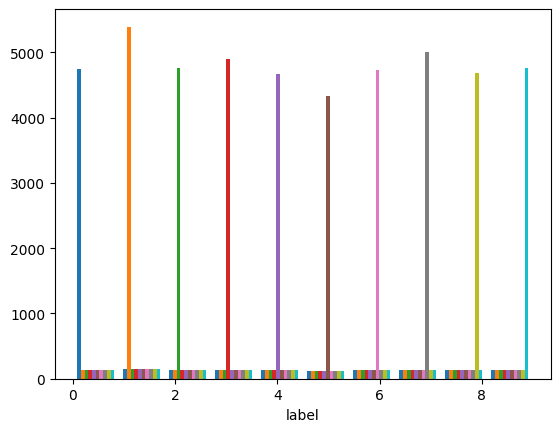

In [31]:
plt.hist(y_train_list, bins=10)
plt.xlabel('label')
plt.show()

### 같은 폴더에 있는 server 파일의 "2번" 코드를 먼저 실행하고 아래 셀을 실행
### 이후 아래 설명과 같이 터미널에서 명령어 실행
### client_noniid.py파일의 DEVICE를 해당 조의 GPU 번호로 변경해야 함

In [32]:
### 같은 폴더에 있는 server 파일의 "1번" 코드를 먼저 실행하고 아래 셀과 clinet1, clinet2 파일을 실행
### client1, client2 파일의 DEVICE를 해당 조의 GPU 번호로 변경해야 함
model_fl = MLP().to(DEVICE)
criterion_fl = nn.CrossEntropyLoss().to(DEVICE)
optimizer_fl = torch.optim.Adam(model_fl.parameters())

In [33]:
client_num = 0

train_dataset_fl = MnistDataSet(x_train_list[client_num], y_train_list[client_num])
test_dataset_fl = MnistDataSet(x_test_list[client_num], y_test_list[client_num])
BATCH_SIZE = 128
train_loader_fl = DataLoader(train_dataset_fl, batch_size=BATCH_SIZE, shuffle=True)
test_loader_fl = DataLoader(test_dataset_fl, batch_size=BATCH_SIZE, shuffle=True)

flwr_client = FlowerClient(model_fl, train_loader_fl, test_loader_fl, optimizer_fl, criterion_fl)

fl.client.start_numpy_client(server_address="127.0.0.1:8080", client=flwr_client)

INFO flwr 2023-08-23 17:46:46,519 | grpc.py:50 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flwr 2023-08-23 17:46:46,526 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flwr 2023-08-23 17:46:46,528 | connection.py:39 | ChannelConnectivity.READY


Train Epoch: 1 [0/5937 (0%)]	Train Loss: 2.411350
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 2.382610
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 2.389538
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.992610
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.616501
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.721717
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.531317
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.601766
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.595659
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.520727
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.495221
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.496512
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.516626
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.534313
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.515913
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.507468
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.500466
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.505557
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.529471
Train Epoch: 1 [0/5937 (0%)]	Train Loss: 1.542331


DEBUG flwr 2023-08-23 17:48:17,060 | connection.py:113 | gRPC channel closed
INFO flwr 2023-08-23 17:48:17,061 | app.py:185 | Disconnect and shut down


## 아래 명령어를 주피터 터미널에서 실행
1. conda activate 를 통해 가상환경에 진입
2. cd 명령어를 통해 MNIST_flower 폴더에 진입 (cd fl_study/MNIST_flower)
3. 아래 명령어 실행

In [ ]:
python client_noniid.py 1 & python client_noniid.py 2 & python client_noniid.py 3 & python client_noniid.py 4 & python client_noniid.py 5 & python client_noniid.py 6 & python client_noniid.py 7 & python client_noniid.py 8 & python client_noniid.py 9 &

In [22]:
loss, accuracy = evaluate(model_fl, test_loader, criterion_fl)
accuracy

39.34